# Information Retrieval: Text Classification

### Nicolas Debrito

## Download Library

In [13]:
# !pip install beautifulsoup4
# !pip install requests
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install sastrawi
# !pip install nltk
# !pip install scikit_learn

## Import Library

In [14]:
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Scraping Data

### Get Tittle from Every Category 

##### Data from 2 May 2024 16.00 WIB

In [15]:
list_news_category = ['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan']
list_news = {'Title': [], 'Link': [], 'Category': []}

news_url = 'https://www.cnnindonesia.com/'

for category in list_news_category:
	news_response = requests.get(news_url+category)
	soup = BeautifulSoup(news_response.content, 'html.parser')

	if category in ('ekonomi', 'olahraga', 'teknologi', 'hiburan'):
		news_title = soup.find_all('h2', class_="text-cnn_black_light dark:text-white mb-2 inline leading-normal text-xl group-hover:text-cnn_red")
		news_title = [title.text.strip() for title in news_title]
		news_link = soup.find_all('a', class_="flex group items-center gap-4")
		news_link = [link['href'] for link in news_link]
		if len(news_link) == len(news_title):
			list_news['Title'].extend(news_title)
			list_news['Link'].extend(news_link)
			list_news['Category'].extend([category]*len(news_title))
		else:
			list_news['Title'].extend(news_title)
			list_news['Link'].extend(news_link[2:])
			list_news['Category'].extend([category]*len(news_title))
	elif category == 'otomotif':
		news_title = soup.find_all('h2', class_="text-white dark:text-white mb-2 inline leading-normal text-xl group-hover:text-cnn_red")
		news_title = [title.text.strip() for title in news_title]
		news_link = soup.find_all('a', class_="flex group items-center gap-4")
		news_link = [link['href'] for link in news_link]
		list_news['Title'].extend(news_title)
		list_news['Link'].extend(news_link)
		list_news['Category'].extend([category]*len(news_title))

news_df = pd.DataFrame(list_news)
news_df

,Title,Link,Category
0,Rupiah Gulingkan Dolar AS ke Rp16.185 Sore Ini,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi
1,Bank Mandiri Siapkan UMKM Hadapi Era Digital d...,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi
2,Jokowi Bongkar Biang Kerok Jatuh Harga Jagung,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi
3,"Jadi Kado Hari Buruh, Tetangga RI Naikkan Gaji...",https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi
4,"Bahlil: Alhamdulillah, Capres-Cawapres Tak Duk...",https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi
...,...,...,...
91,"Sinopsis The Architecture of Love, Asmara Penu...",https://www.cnnindonesia.com/hiburan/202405010...,hiburan
92,William Ungkap Kondisi Kesehatan Terbaru Kate ...,https://www.cnnindonesia.com/hiburan/202405010...,hiburan
93,"Profil Ryohei Suzuki, Aktor Populer Jepang Pem...",https://www.cnnindonesia.com/hiburan/202404301...,hiburan
94,Jazz Gunung Gelar Golo Mori Jazz 2024 pada 16 ...,https://www.cnnindonesia.com/hiburan/202404302...,hiburan


### Get Article from Link Article

In [16]:
list_article = []

for link in news_df['Link']:
    article_response = requests.get(link)
    soup = BeautifulSoup(article_response.content, 'html.parser')
    
    news_article = soup.find('div', class_="detail-text text-cnn_black text-sm grow min-w-0")
    paragraphs = news_article.find_all('p')
    
    if paragraphs:
        article_text = [p.get_text(separator='\n', strip=True).replace('\n', ' ') for p in paragraphs if not p.get('class')]
        article_text_join = " ".join(article_text)
        list_article.append(article_text_join)
    else:
        list_article.append(news_article.text.strip())

news_df['Article'] = list_article
news_df

,Title,Link,Category,Article
0,Rupiah Gulingkan Dolar AS ke Rp16.185 Sore Ini,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Nilai tukar rupiah ditutup di level Rp16.185 p...
1,Bank Mandiri Siapkan UMKM Hadapi Era Digital d...,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,"Di era digitalisasi yang kian pesat, Bank Mand..."
2,Jokowi Bongkar Biang Kerok Jatuh Harga Jagung,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Presiden Joko Widodo ( Jokowi ) menyoroti penu...
3,"Jadi Kado Hari Buruh, Tetangga RI Naikkan Gaji...",https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Malaysia akan menaikkan gaji pegawai negeri si...
4,"Bahlil: Alhamdulillah, Capres-Cawapres Tak Duk...",https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Menteri Investasi/Kepala BKPM Bahlil Lahadalia...
...,...,...,...,...
91,"Sinopsis The Architecture of Love, Asmara Penu...",https://www.cnnindonesia.com/hiburan/202405010...,hiburan,The Architecture of Love menjadi film terbaru ...
92,William Ungkap Kondisi Kesehatan Terbaru Kate ...,https://www.cnnindonesia.com/hiburan/202405010...,hiburan,Pangeran William buka suara mengenai kondisi K...
93,"Profil Ryohei Suzuki, Aktor Populer Jepang Pem...",https://www.cnnindonesia.com/hiburan/202404301...,hiburan,Manga populer City Hunter akhirnya dibuat vers...
94,Jazz Gunung Gelar Golo Mori Jazz 2024 pada 16 ...,https://www.cnnindonesia.com/hiburan/202404302...,hiburan,Jazz Gunung Indonesia akan menggelar konser In...


### Save to CSV File

In [17]:
news_df.to_csv('news_data.csv', index=False)

## Preprocessing

### Load data text from CSV file

In [18]:
df_preprocessed = pd.read_csv('news_data.csv')
df_preprocessed

,Title,Link,Category,Article
0,Rupiah Gulingkan Dolar AS ke Rp16.185 Sore Ini,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Nilai tukar rupiah ditutup di level Rp16.185 p...
1,Bank Mandiri Siapkan UMKM Hadapi Era Digital d...,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,"Di era digitalisasi yang kian pesat, Bank Mand..."
2,Jokowi Bongkar Biang Kerok Jatuh Harga Jagung,https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Presiden Joko Widodo ( Jokowi ) menyoroti penu...
3,"Jadi Kado Hari Buruh, Tetangga RI Naikkan Gaji...",https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Malaysia akan menaikkan gaji pegawai negeri si...
4,"Bahlil: Alhamdulillah, Capres-Cawapres Tak Duk...",https://www.cnnindonesia.com/ekonomi/202405021...,ekonomi,Menteri Investasi/Kepala BKPM Bahlil Lahadalia...
...,...,...,...,...
91,"Sinopsis The Architecture of Love, Asmara Penu...",https://www.cnnindonesia.com/hiburan/202405010...,hiburan,The Architecture of Love menjadi film terbaru ...
92,William Ungkap Kondisi Kesehatan Terbaru Kate ...,https://www.cnnindonesia.com/hiburan/202405010...,hiburan,Pangeran William buka suara mengenai kondisi K...
93,"Profil Ryohei Suzuki, Aktor Populer Jepang Pem...",https://www.cnnindonesia.com/hiburan/202404301...,hiburan,Manga populer City Hunter akhirnya dibuat vers...
94,Jazz Gunung Gelar Golo Mori Jazz 2024 pada 16 ...,https://www.cnnindonesia.com/hiburan/202404302...,hiburan,Jazz Gunung Indonesia akan menggelar konser In...


### Merge all row value in column "Article"

In [19]:
text_article = df_preprocessed['Article']
text_article

0     Nilai tukar rupiah ditutup di level Rp16.185 p...
1     Di era digitalisasi yang kian pesat, Bank Mand...
2     Presiden Joko Widodo ( Jokowi ) menyoroti penu...
3     Malaysia akan menaikkan gaji pegawai negeri si...
4     Menteri Investasi/Kepala BKPM Bahlil Lahadalia...
                            ...                        
91    The Architecture of Love menjadi film terbaru ...
92    Pangeran William buka suara mengenai kondisi K...
93    Manga populer City Hunter akhirnya dibuat vers...
94    Jazz Gunung Indonesia akan menggelar konser In...
95    Penyanyi Virzha mengonfirmasi dirinya baru saj...
Name: Article, Length: 96, dtype: object

### Tokenization

In [20]:
tokenize_text = [word_tokenize(text.lower()) for text in text_article]
print(tokenize_text)

[['nilai', 'tukar', 'rupiah', 'ditutup', 'di', 'level', 'rp16.185', 'per', 'dolar', 'as', 'pada', 'kamis', '(', '2/5', ')', '.', 'mata', 'uang', 'garuda', 'menguat', '74', 'poin', 'atau', 'plus', '0,46', 'persen', 'dari', 'penutupan', 'perdagangan', 'sebelumnya', '.', 'sementara', ',', 'kurs', 'referensi', 'bank', 'indonesia', '(', 'bi', ')', 'jakarta', 'interbank', 'spot', 'dollar', 'rate', '(', 'jisdor', ')', 'menempatkan', 'rupiah', 'ke', 'posisi', 'rp16.202', 'per', 'dolar', 'as', 'pada', 'perdagangan', 'sore', 'ini', '.', 'serupa', ',', 'mata', 'uang', 'di', 'kawasan', 'asia', 'juga', 'dominan', 'menguat', '.', 'dolar', 'hong', 'kong', 'naik', '0,08', 'persen', ',', 'dolar', 'singapura', 'plus', '0,15', 'persen', ',', 'baht', 'thailand', 'tumbuh', '0,32', 'persen', ',', 'ringgit', 'malaysia', 'menguat', '0,35', 'persen', ',', 'peso', 'filipina', 'bangkit', '0,51', 'persen', ',', 'dan', 'won', 'korea', 'selatan', 'melesat', '0,83', 'persen', '.', 'pelemahan', 'dialami', 'oleh', 'ru

### Stopword Removal

In [21]:
stopword_indo = stopwords.words('indonesian')

filtered_text = [word for word in tokenize_text if word not in stopword_indo]
print(filtered_text)

[['nilai', 'tukar', 'rupiah', 'ditutup', 'di', 'level', 'rp16.185', 'per', 'dolar', 'as', 'pada', 'kamis', '(', '2/5', ')', '.', 'mata', 'uang', 'garuda', 'menguat', '74', 'poin', 'atau', 'plus', '0,46', 'persen', 'dari', 'penutupan', 'perdagangan', 'sebelumnya', '.', 'sementara', ',', 'kurs', 'referensi', 'bank', 'indonesia', '(', 'bi', ')', 'jakarta', 'interbank', 'spot', 'dollar', 'rate', '(', 'jisdor', ')', 'menempatkan', 'rupiah', 'ke', 'posisi', 'rp16.202', 'per', 'dolar', 'as', 'pada', 'perdagangan', 'sore', 'ini', '.', 'serupa', ',', 'mata', 'uang', 'di', 'kawasan', 'asia', 'juga', 'dominan', 'menguat', '.', 'dolar', 'hong', 'kong', 'naik', '0,08', 'persen', ',', 'dolar', 'singapura', 'plus', '0,15', 'persen', ',', 'baht', 'thailand', 'tumbuh', '0,32', 'persen', ',', 'ringgit', 'malaysia', 'menguat', '0,35', 'persen', ',', 'peso', 'filipina', 'bangkit', '0,51', 'persen', ',', 'dan', 'won', 'korea', 'selatan', 'melesat', '0,83', 'persen', '.', 'pelemahan', 'dialami', 'oleh', 'ru

### Stemming

In [22]:
length = len(filtered_text)
stemmer = StemmerFactory().create_stemmer()

for i in range(length):
    filtered_text[i] = [stemmer.stem(word) for word in filtered_text[i]]
print(filtered_text)

for i in range(length):
    filtered_text[i] = [word for word in filtered_text[i] if word and word.isalpha()]
print(filtered_text)

[['nilai', 'tukar', 'rupiah', 'tutup', 'di', 'level', 'rp16 185', 'per', 'dolar', 'as', 'pada', 'kamis', '', '2 5', '', '', 'mata', 'uang', 'garuda', 'kuat', '74', 'poin', 'atau', 'plus', '0 46', 'persen', 'dari', 'tutup', 'dagang', 'belum', '', 'sementara', '', 'kurs', 'referensi', 'bank', 'indonesia', '', 'bi', '', 'jakarta', 'interbank', 'spot', 'dollar', 'rate', '', 'jisdor', '', 'tempat', 'rupiah', 'ke', 'posisi', 'rp16 202', 'per', 'dolar', 'as', 'pada', 'dagang', 'sore', 'ini', '', 'rupa', '', 'mata', 'uang', 'di', 'kawasan', 'asia', 'juga', 'dominan', 'kuat', '', 'dolar', 'hong', 'kong', 'naik', '0 08', 'persen', '', 'dolar', 'singapura', 'plus', '0 15', 'persen', '', 'baht', 'thailand', 'tumbuh', '0 32', 'persen', '', 'ringgit', 'malaysia', 'kuat', '0 35', 'persen', '', 'peso', 'filipina', 'bangkit', '0 51', 'persen', '', 'dan', 'won', 'korea', 'selatan', 'lesat', '0 83', 'persen', '', 'lemah', 'alami', 'oleh', 'rupee', 'india', 'yang', 'turun', '0 01', 'persen', '', 'yuan', '

### Remove duplicate words

In [23]:
remove_duplicate = []
for text in filtered_text:
    for word in text :
        if word not in remove_duplicate:
            remove_duplicate.append(word)
print(remove_duplicate)

['nilai', 'tukar', 'rupiah', 'tutup', 'di', 'level', 'per', 'dolar', 'as', 'pada', 'kamis', 'mata', 'uang', 'garuda', 'kuat', 'poin', 'atau', 'plus', 'persen', 'dari', 'dagang', 'belum', 'sementara', 'kurs', 'referensi', 'bank', 'indonesia', 'bi', 'jakarta', 'interbank', 'spot', 'dollar', 'rate', 'jisdor', 'tempat', 'ke', 'posisi', 'sore', 'ini', 'rupa', 'kawasan', 'asia', 'juga', 'dominan', 'hong', 'kong', 'naik', 'singapura', 'baht', 'thailand', 'tumbuh', 'ringgit', 'malaysia', 'peso', 'filipina', 'bangkit', 'dan', 'won', 'korea', 'selatan', 'lesat', 'lemah', 'alami', 'oleh', 'rupee', 'india', 'yang', 'turun', 'yuan', 'china', 'merosot', 'yen', 'jepang', 'ambruk', 'bahkan', 'negara', 'maju', 'serempak', 'perkasa', 'poundsterling', 'inggris', 'euro', 'eropa', 'franc', 'swiss', 'kanada', 'australia', 'amat', 'komoditas', 'lukman', 'leong', 'kata', 'hadap', 'berkat', 'reda', 'tekan', 'suku', 'bunga', 'the', 'fed', 'jadi', 'telah', 'federal', 'open', 'market', 'committee', 'fomc', 'malam

### Calculate sum words

In [24]:
sentences_code = [f"D{i+1}" for i in range(length)]
word_count = dict.fromkeys(sentences_code, {})
for keys in word_count:
    word_count[keys] = dict.fromkeys(remove_duplicate, 0)
for i in range(length):
    for word in filtered_text[i]:
        word_count[sentences_code[i]][word] += 1

df = pd.DataFrame(word_count).fillna(0)
df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96
nilai,1,2,0,0,2,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
tukar,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rupiah,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tutup,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
di,2,5,7,3,13,6,11,5,12,11,...,3,3,8,5,0,7,4,8,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
drum,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
mixing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
gengsi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
devirzha,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Calculate DF and IDF value for each document

In [25]:
df.index.name = 'Term'

sentences_code = df.columns.to_list()
length = len(sentences_code)

df['DF'] = df.sum(axis=1)
df['IDF'] = df['DF'].apply(lambda x: round(math.log10(length/x), 5))
for i in range(length):
    df[f'TF-IDF D{i+1}'] = df[sentences_code[i]] * df['IDF']
df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,TF-IDF D87,TF-IDF D88,TF-IDF D89,TF-IDF D90,TF-IDF D91,TF-IDF D92,TF-IDF D93,TF-IDF D94,TF-IDF D95,TF-IDF D96
Term,,,,,,,,,,,,,,,,,,,,,
nilai,1,2,0,0,2,0,0,0,0,0,...,0.63985,0.00000,0.00000,0.63985,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
tukar,1,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
rupiah,3,1,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
tutup,2,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
di,2,5,7,3,13,6,11,5,12,11,...,-2.39844,-2.39844,-6.39584,-3.99740,-0.0,-5.59636,-3.19792,-6.39584,-4.79688,-2.39844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
drum,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227
mixing,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227
gengsi,0,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227


### Save result DF & IDF to CSV

In [70]:
df.to_csv('tf_idf.csv')

## Model Classification

### Load Data from CSV

In [71]:
terms_df = pd.read_csv('tf_idf.csv')
terms_df

,Term,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,TF-IDF D87,TF-IDF D88,TF-IDF D89,TF-IDF D90,TF-IDF D91,TF-IDF D92,TF-IDF D93,TF-IDF D94,TF-IDF D95,TF-IDF D96
0,nilai,1,2,0,0,2,0,0,0,0,...,0.63985,0.00000,0.00000,0.63985,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
1,tukar,1,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
2,rupiah,3,1,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
3,tutup,2,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
4,di,2,5,7,3,13,6,11,5,12,...,-2.39844,-2.39844,-6.39584,-3.99740,-0.0,-5.59636,-3.19792,-6.39584,-4.79688,-2.39844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3839,drum,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227
3840,mixing,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227
3841,gengsi,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227
3842,devirzha,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,1.98227


### Take TF-IDF from Dataframe

In [72]:
list_category = ['ekonomi']*20 + ['olahraga']*20 + ['teknologi']*20 + ['otomotif']*16 + ['hiburan']*20

single_terms_df = terms_df.iloc[:, 0]
tf_idf_df = terms_df.iloc[:, 99:]

concatenated_df = pd.concat([single_terms_df, tf_idf_df], axis=1)

transpose_df = concatenated_df.iloc[:, :].T
transpose_df.columns = concatenated_df.iloc[:, 0]

finally_df = transpose_df.iloc[1:, :].copy()
finally_df['Category'] = list_category
finally_df

Term,nilai,tukar,rupiah,tutup,di,level,per,dolar,as,pada,...,impi,istri,dinyanyiin,manajemen,drum,mixing,gengsi,devirzha,indie,Category
TF-IDF D1,0.63985,1.20412,3.23754,1.2797,-1.59896,1.13717,0.98182,5.44705,1.47796,-0.89496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ekonomi
TF-IDF D2,1.2797,0.0,1.07918,0.0,-3.9974,0.0,0.0,0.0,0.0,-1.34244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ekonomi
TF-IDF D3,0.0,0.0,0.0,0.0,-5.59636,0.0,0.0,0.0,0.0,-0.44748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ekonomi
TF-IDF D4,0.0,0.0,0.0,0.0,-2.39844,1.13717,0.49091,1.5563,0.73898,-1.34244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ekonomi
TF-IDF D5,1.2797,0.0,0.0,0.0,-10.39324,0.0,0.0,0.0,0.0,-0.44748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ekonomi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TF-IDF D92,0.0,0.0,0.0,0.0,-5.59636,0.0,0.98182,0.0,0.0,-0.44748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hiburan
TF-IDF D93,0.0,0.0,0.0,0.0,-3.19792,0.0,0.0,0.0,0.0,-2.68488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hiburan
TF-IDF D94,0.0,0.0,0.0,0.0,-6.39584,0.0,1.47273,0.0,0.0,-4.4748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hiburan
TF-IDF D95,0.0,0.0,0.0,0.0,-4.79688,0.0,0.0,0.0,0.0,-0.44748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hiburan


### Split Data for Trainset and Testset

In [73]:
X_train, X_test, y_train, y_test = train_test_split(finally_df.iloc[:, :-1], finally_df.iloc[:, -1], test_size=0.2, random_state=1)

### K-Nearest Neighbors Classification

In [74]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}
knn_model_cv = GridSearchCV(knn_model, param_grid=param_grid, cv=3,scoring='accuracy')

knn_model_cv.fit(X_train, y_train)
print(knn_model_cv.best_estimator_)

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')


In [92]:
knn_model = KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_pred_knn

array(['hiburan', 'olahraga', 'hiburan', 'hiburan', 'hiburan', 'hiburan',
       'otomotif', 'hiburan', 'otomotif', 'hiburan', 'otomotif',
       'olahraga', 'hiburan', 'hiburan', 'olahraga', 'otomotif',
       'olahraga', 'hiburan', 'hiburan', 'olahraga'], dtype=object)

In [93]:
accuracy = accuracy_score(y_test, y_pred_knn)
print(accuracy)

0.55


### Naive Bayes Classification

In [94]:
nb_model = GaussianNB()

param_grid_gaussian = {
    'var_smoothing': [1e-9, 1e-8, 1e-7] 
}

nb_model_cv = GridSearchCV(nb_model, param_grid_gaussian, cv=3)

nb_model_cv.fit(X_train, y_train)
print(nb_model_cv.best_estimator_)

GaussianNB()


In [95]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
y_pred_nb

array(['teknologi', 'olahraga', 'teknologi', 'ekonomi', 'hiburan',
       'teknologi', 'otomotif', 'teknologi', 'hiburan', 'hiburan',
       'otomotif', 'olahraga', 'hiburan', 'hiburan', 'olahraga',
       'ekonomi', 'olahraga', 'teknologi', 'ekonomi', 'olahraga'],
      dtype='<U9')

In [96]:
accuracy = accuracy_score(y_test, y_pred_nb)
print(accuracy)

0.8


### Support Vector Machine Classification

In [97]:
svc_model = SVC()

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'], 
    'degree': [2, 3],
    'coef0': [0.0, 0.5]
}

svc_model_cv = GridSearchCV(svc_model, param_grid_svc, cv=3)
svc_model_cv.fit(X_train, y_train)
print(svc_model_cv.best_estimator_)

SVC(C=10, degree=2, gamma='auto')


In [98]:
svc_model = SVC(C=10, degree=2, gamma='auto')
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_pred_svc

array(['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan',
       'otomotif', 'otomotif', 'teknologi', 'hiburan', 'hiburan',
       'otomotif', 'olahraga', 'hiburan', 'hiburan', 'olahraga',
       'ekonomi', 'olahraga', 'ekonomi', 'ekonomi', 'olahraga'],
      dtype=object)

In [99]:
accuracy = accuracy_score(y_test, y_pred_svc)
print(accuracy)

0.85


## Evaluation

### Confusion Matrix for KNN Model

In [100]:
confusion = confusion_matrix(y_test, y_pred_knn, labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
print(confusion)

[[0 0 0 0 2]
 [0 5 0 0 0]
 [0 0 0 1 4]
 [0 0 0 2 1]
 [0 0 0 1 4]]


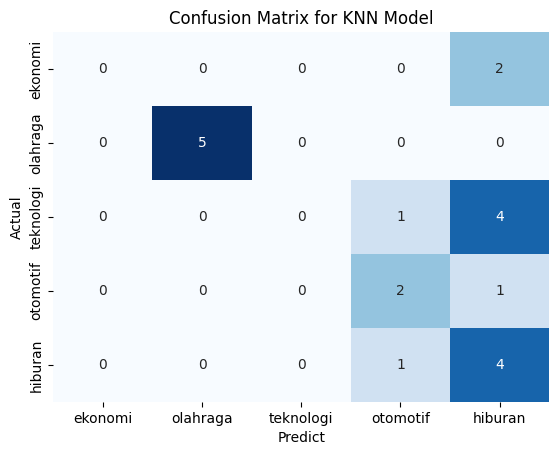

In [101]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predict')
plt.xticks(ticks=[i + 0.5 for i in range(5)], labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
plt.ylabel('Actual')
plt.yticks(ticks=[i + 0.5 for i in range(5)], labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
plt.show()

In [102]:
report = classification_report(y_test, y_pred_knn)
print(report)

              precision    recall  f1-score   support

     ekonomi       0.00      0.00      0.00         2
     hiburan       0.36      0.80      0.50         5
    olahraga       1.00      1.00      1.00         5
    otomotif       0.50      0.67      0.57         3
   teknologi       0.00      0.00      0.00         5

    accuracy                           0.55        20
   macro avg       0.37      0.49      0.41        20
weighted avg       0.42      0.55      0.46        20



c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Confusion Matrix for Naive Bayes Model

In [103]:
confusion = confusion_matrix(y_test, y_pred_nb, labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
print(confusion)

[[1 0 1 0 0]
 [0 5 0 0 0]
 [2 0 3 0 0]
 [0 0 1 2 0]
 [0 0 0 0 5]]


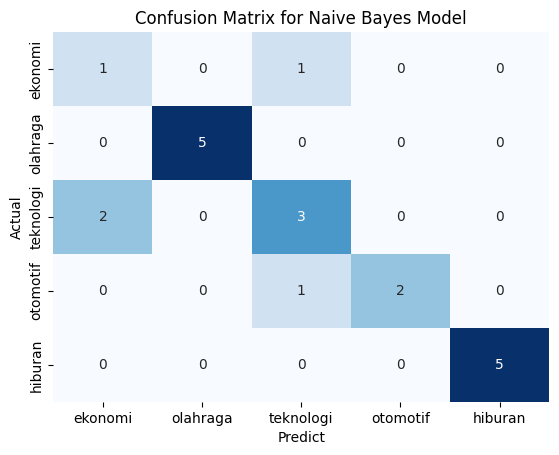

In [104]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Naive Bayes Model')
plt.xlabel('Predict')
plt.xticks(ticks=[i + 0.5 for i in range(5)], labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
plt.ylabel('Actual')
plt.yticks(ticks=[i + 0.5 for i in range(5)], labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
plt.show()

In [105]:
report = classification_report(y_test, y_pred_nb)
print(report)

              precision    recall  f1-score   support

     ekonomi       0.33      0.50      0.40         2
     hiburan       1.00      1.00      1.00         5
    olahraga       1.00      1.00      1.00         5
    otomotif       1.00      0.67      0.80         3
   teknologi       0.60      0.60      0.60         5

    accuracy                           0.80        20
   macro avg       0.79      0.75      0.76        20
weighted avg       0.83      0.80      0.81        20



### Confusion Matrix for SVM Model

In [106]:
confusion = confusion_matrix(y_test, y_pred_svc, labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
print(confusion)

[[2 0 0 0 0]
 [0 5 0 0 0]
 [2 0 2 1 0]
 [0 0 0 3 0]
 [0 0 0 0 5]]


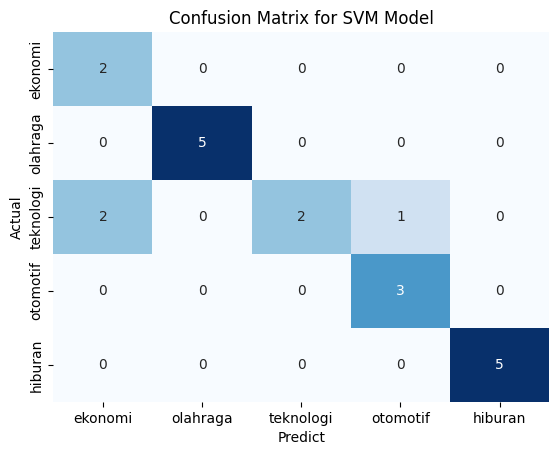

In [107]:
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Predict')
plt.xticks(ticks=[i + 0.5 for i in range(5)], labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
plt.ylabel('Actual')
plt.yticks(ticks=[i + 0.5 for i in range(5)], labels=['ekonomi', 'olahraga', 'teknologi', 'otomotif', 'hiburan'])
plt.show()

In [108]:
report = classification_report(y_test, y_pred_svc)
print(report)

              precision    recall  f1-score   support

     ekonomi       0.50      1.00      0.67         2
     hiburan       1.00      1.00      1.00         5
    olahraga       1.00      1.00      1.00         5
    otomotif       0.75      1.00      0.86         3
   teknologi       1.00      0.40      0.57         5

    accuracy                           0.85        20
   macro avg       0.85      0.88      0.82        20
weighted avg       0.91      0.85      0.84        20

